## Импорт зависимостей

In [ ]:
!pip install torchtext==0.9.1 # библиотека для работы с текстами в pytorch
!pip install natasha # библиотека с утилитами для работы с русским языком
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar # загружаем предобученные эмбеддинги для русских слов

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import sklearn.metrics as sm # библиотека с различными метриками качества
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords # стоп-слова русского языка
from string import punctuation # список пунктуации

import os
import random

import torch

import torch.nn as nn
import torch.optim

from tqdm.notebook import tqdm_notebook as tqdm # библиотека для визуализации затрачиваемого на выполнение кода времени
from tqdm.notebook import trange
from torch.utils.data import DataLoader # библиотека для создания DataLoader
import torch.nn.functional as F # библиотека с функциями pytorch
from navec import Navec # библиотека для работы со скаченными эмбеддингами
import razdel # утилита из библиотеки natasha, которая очень хорошо токенизирует русские предложения
import copy
import pymorphy2 # утилита с нейросетевой тэгизацией слов

* Библиотека razdel в этой задаче необходима, потому что предложения в этой задаче содержат сложные слова для обычного токенизатора, содержат много сокращений и точек не в конце предложений.
https://github.com/natasha/razdel
* Библиотека pymorphy2 необходима, чтобы привести слова к нормальной форме и заменить все числа общим токеном -NUMB-
https://pymorphy2.readthedocs.io/en/stable/

## Функция для того, чтобы зафиксировать все случайные величины и обеспечить воспроизводимость результатов

In [3]:
SEED = 1234


def enable_reproducibility(
        seed=SEED, raise_if_no_deterministic=True,
        cudnn_deterministic=True, disable_cudnn_benchmarking=True):
    # https://pytorch.org/docs/stable/notes/randomness.html#avoiding-nondeterministic-algorithms
    torch.use_deterministic_algorithms(raise_if_no_deterministic)

    # https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"
    
    torch.backends.cudnn.benchmark = not disable_cudnn_benchmarking
    torch.backends.cudnn.deterministic = cudnn_deterministic

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
enable_reproducibility()

## Загрузка данных

In [5]:
from google.colab import drive # подключаем гугл-диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
data = pd.read_json(r'/content/drive/MyDrive/ColabNotebooks/dataset-shop.json', lines=True) # загружаем данные. Они в формате json
data = data.sample(frac=1).reset_index(drop=True)[:500000] # данных очень много (более 4 млн), поэтому обрежем их и оставим 500 тысяч записей

Взглянем на данные

In [18]:
print(data.shape) 
data.head()

(500000, 2)


,title,dir
0,Фен строительный ЗУБР ФТ-П1800 К,tools
1,АВТОМАТИЧЕСКИЙ выключатель iC60L 4П 25A K,electro
2,Отвертка ударная крестовая PH2x100mm,tools
3,Цифровой панельный измеритель M4W2P-AVR-4 AC19...,electro
4,"Лента нержавеющая 0,75 мм 15Х18Н12С4ТЮ ГОСТ 49...",metal


Посмотрим на распределение классов

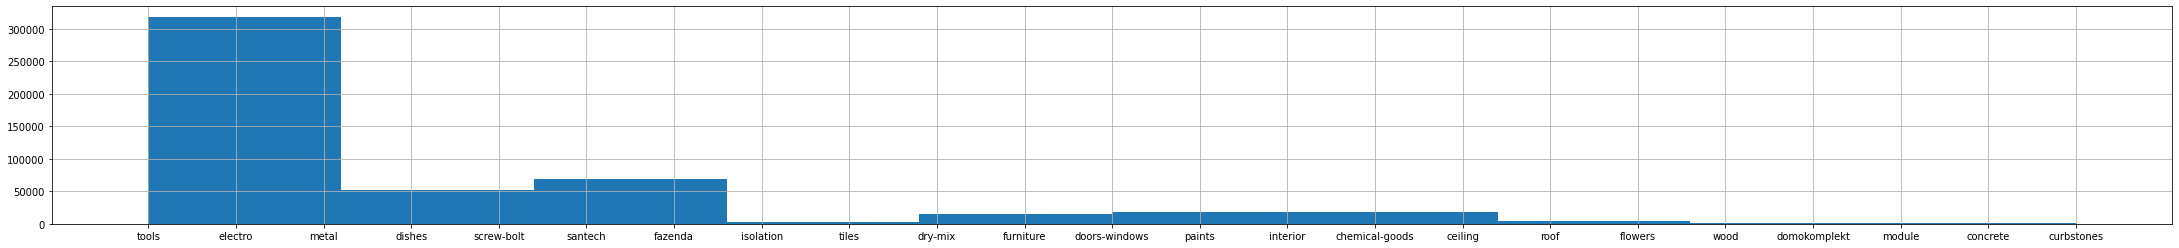

In [19]:
plt.figure(figsize=(38, 4))
data.dir.hist()

Заметно, что классы не сбалансированны

## Предобработка данных

Стоп-слова - это слова, не имеющие смысла в контексте решения задачи классификации текстов.

In [20]:
nltk.download('stopwords') # скачиваем стоп-слова
ru_stopwords = nltk.corpus.stopwords.words('russian')
print(ru_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'на

Создадим морфологический анализатор

In [21]:
morph = pymorphy2.MorphAnalyzer()

Функция препроцессинга удаляет пунктуацию, удаляет стоп-слова, и слова, которые очень часто встречаются в датасете, но не имеют никакого смысла (drop-tokens). Затем функция приводит слова к нормальной форме, заменяет числа на общую абстракцию -NUMB- и заменяет английскую букву х на английскую х. Это необходимо для того, чтобы площадь разных объектов имела одинаковое значение (Например, Фанера 200х40 м.)

In [22]:
def preproc(sentence):
  tokens = [_.text.lower() for _ in list(razdel.tokenize(str(sentence)))]

  final_sentence = []
  drop_tokens = ['a', 'd', 'e', 'l', 'н', 'p', 'п', 'w', 'g', 'r', 'b', 'ip', '«', '»', 'ф', 'ду', 'б']

  for token  in tokens:
    if (token not in ru_stopwords and token not in punctuation and token not in drop_tokens):
      if token == 'х':
          token = 'x'
      parsed_token = morph.parse(token)[0]
      if 'NUMB' not in parsed_token.tag:
        final_sentence.append(str(parsed_token.normal_form))

  return final_sentence

In [23]:
tqdm.pandas() # чтобы отображалось время применения функции
%time data['title'] = data['title'].progress_apply(preproc)

  0%|          | 0/500000 [00:00<?, ?it/s]

CPU times: user 19min 7s, sys: 15.2 s, total: 19min 22s
Wall time: 21min 6s


In [24]:
data.head()

,title,dir
0,"[фен, строительный, зубр, фт-п]",tools
1,"[автоматический, выключатель, ic, k]",electro
2,"[отвёртка, ударный, крестовый, ph, x, mm]",tools
3,"[цифровой, панельный, измеритель, m, p-avr-4, ...",electro
4,"[лента, нержавеющий, мм, x, тю, гост, 4986-79,...",metal


Проведем простую аугментацию данных для тех классов, количество которых небольшое. Преобразование заключается в том, что создаются дополнительные названия товаров как инвертированные исходные названия (Например, Например, Фанера Деревянная 200х40 -> 200х40 Деревянная Фанера)

In [25]:
augment_data = pd.DataFrame(columns=['title', 'dir'])

for column in ['domokomplekt', 'module', 'curbstones', 'concrete', 'tiles', 'wood', 'isolation', 'flowers', 'dry-mix']:
    augment_data = pd.concat([augment_data, data[data['dir'] == column].apply(lambda x: x.reverse() if type(x) == list else x)], axis=0)
    
data = pd.concat([data, augment_data.reset_index(drop=True)], axis=0).reset_index(drop=True)

## Формирование словаря

Посмотрим сколько всего у нас классов

In [26]:
n_classes = len(data['dir'].unique())
print(n_classes)

23


Создадим словарь слов

In [38]:
from collections import Counter
from itertools import chain

from torchtext.vocab import Vocab

PAD_TOKEN = '<pad>'  # специальный токен для паддинга, чтобы можно было объединять данные в батчи
UNK_TOKEN = '<unk>'  # специальный токен для незнакомых слов

words_counter = Counter(chain.from_iterable(map(lambda w: w.lower(), words) for words in 
                                            pd.concat([data['title']], axis=0))) # создадим словарь формата {слово: частота}
words_vocab = Vocab(words_counter, min_freq=10,  specials=(PAD_TOKEN, UNK_TOKEN)) # опираясь на ранее созданный словарь, создадим другой словарь формата {индекс: слово}

PAD_IDX = words_vocab.stoi[PAD_TOKEN] # запомним индекс токена паддинга

print(f"Уникальные токены в словаре: {len(words_vocab)}")

Уникальные токены в словаре: 18240


In [39]:
print(words_vocab.itos[:200]) # выведем первые 200 токенов словаря

['<pad>', '<unk>', 'x', 'мм', 'м', 'шт', 'кабель', 'гост', 'смотреть', 'сверло', 'труба', 'electric', 'светодиодный', 'schneider', 'л', 'светильник', 'зубр', 'белый', 'лампа', 'так', 'г', 'кг', 's', 'c', 'вт', 'm', 'нержавеющий', 'f', 'выключатель', 'набор', 'мл', 'круг', 'артикул', 'розетка', 'ст', 'самореза', 'чёрный', 'v', 'р', 'стальной', 'quot', 'abb', 'n', 'ключ', 'сталь', 'цвет', 'далее', 'лист', 'универсальный', 't', 'металл', 'din', 'насос', '1/2', 'комплект', 'лента', 'подвесной', 'phoenix', 'диск', 'contact', 'stayer', 'h', 'ручка', 'смеситель', 'люстра', 'дерево', 'алюминиевый', 'головка', 'k', 'россия', 'автоматический', 'сибртех', 'рамка', 'matrix', 'полоса', 'болт', 'legrand', 'led', 'уп', 'bosch', 'шкаф', 'тройник', 'угол', 'aisi', 'стать', 'серый', '№', 'горячекатаный', 'мастер', 'camozzi', 'обои', 'mm', 'хром', 'пильный', 'арт', 'пвх', 'тип', 'гр', 'панель', 'плата', 'дуб', 'ph', 'крышка', 'отвёртка', 'аккумуляторный', 'потолочный', 'конструкционный', 'u', 'дтс', 'ком

## Инициализация эмбеддингов

In [40]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar') # загрузим эмбеддинги

In [41]:
embed_weights = [[]] * len(words_vocab)
navec_indices = []

for i in range(len(words_vocab)):
  token = words_vocab.itos[i]
  try:
    embed_weights[i] = navec[token]
    navec_indices.append(i)
  except:
    embed_weights[i] = np.random.uniform(-1,1,300) # для тех слов, эмбеддингов которых у нас нет инициализируем эмбеддинг случайным шумом из равномерного распределения

navec_indices = torch.LongTensor(navec_indices)
embed_weights = torch.tensor(embed_weights, requires_grad=True, dtype=torch.float32)

из 5637 токенов у 3423 есть предобученные эмбеддинги

In [42]:
print(embed_weights.shape)
print(navec_indices.shape)

torch.Size([18240, 300])
torch.Size([7631])


Посмотрим с насколько большими предложениями мы имеем дело

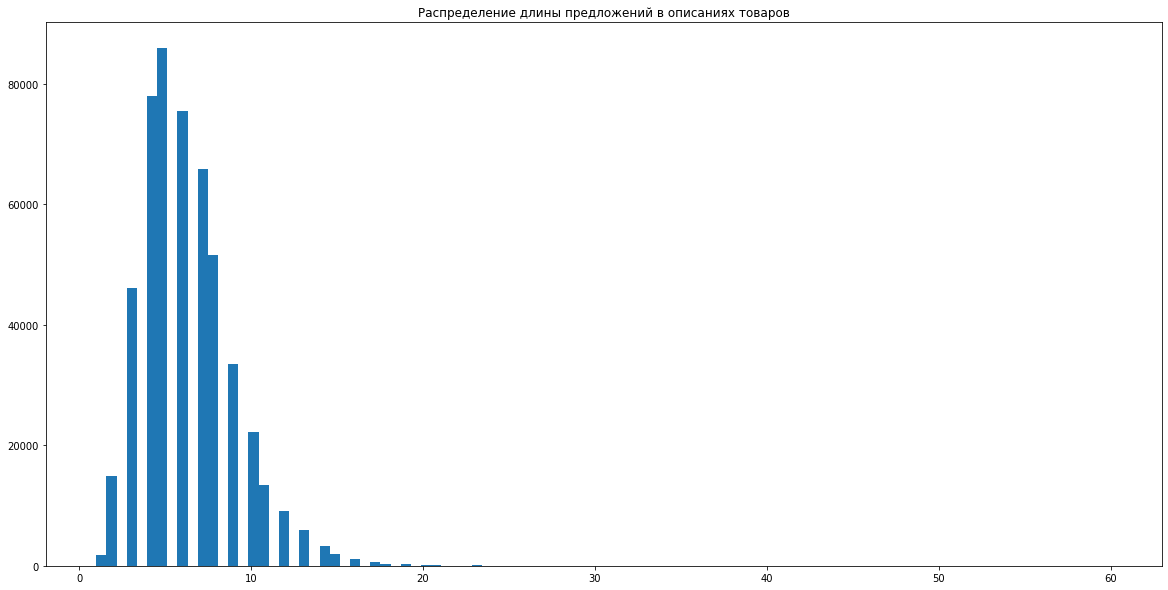

In [32]:
lengths = map(lambda words_tags: len(words_tags), data['title'])

plt.figure(figsize=[20, 10])
plt.title("Распределение длины предложений в описаниях товаров")
plt.hist(list(lengths), bins=100);

In [33]:
# подключим cuda для работы с gpu. Это позволит обучить нейросеть быстро
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Кодировщик меток классов

Закодируем метки классов в числа, чтобы можно было начать обучать модель

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(data['dir'])

LabelEncoder()

In [35]:
data['dir'] = le.transform(data['dir'])

## Функции, необходимые для составления DataLoader'ов, обучения и валидации нейросети

In [36]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# преобразует токены в индексы
def tokens_transform(tokens):
    return [words_vocab.stoi[token] for token in tokens]

# преобразует индексы в токены
def tokens_inverse_transform(indexes):
    return [words_vocab.itos[idx] for idx in indexes]

# формирует батч для обучения нейросети
def collate_batch(batch):
    labels_list, title_t_list = [], []
    for title, label in batch:
        labels_list.append(torch.tensor(label))
        title_t_indices = tokens_transform(title)

        title_t_list.append(torch.tensor(title_t_indices))
    return {
        "title": pad_sequence(title_t_list, batch_first=True, padding_value=PAD_IDX).int(),
        "dir": torch.tensor(labels_list)
    }

# формирует тестовый батч для валидации нейросети (отсутствует метка класса)
def test_collate_batch(batch):
    title_t_list = []
    for title in batch:
        title_t_indices = tokens_transform(title[0])
        title_t_list.append(torch.tensor(title_t_indices))

    return {
        "title": pad_sequence(title_t_list, batch_first=True, padding_value=PAD_IDX).int()
    }

In [37]:
BATCH_SIZE = 160  # размер батча (количество описаний, которые подаются в нейросеть в каждой итерации)

train_loader = DataLoader(data.values, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True, drop_last=True)

In [43]:
# метод для тренировки модели
def training(model, criterion, optimizer, num_epochs, train_loader, valid_loader=None, sheduler=None, max_grad_norm=2, freezing_epochs=0):
    """
    max_grad_norm - ограничение для исключения ситуации взрыва градиента
    freezing_epochs - заморозка эмбеддингов модели на n количество эпох. Необходимо для того, чтобы не испортить предобученные эмбеддинги в начале обучения почти случайными значениями градиента
    sheduler - расписание изменения политики градиента (контроль его величины)
    criterion - оптимизируемая функция
    """
    for e in trange(num_epochs, leave=False):
        model.train()
        
        clf_report = None
        target_names = [str(label) for label in le.inverse_transform(data['dir'].unique())]
        
        valid_acc = 0
        num_iter = 0
        train_loss = 0
        correct = 0
        num_objs = 0

        pbar = tqdm(train_loader, leave=False)
        for batch in pbar:
            optimizer.zero_grad()
            labels = batch["dir"].to(device)
            prediction = model(batch["title"].to(device))
            loss = criterion(prediction, labels)
            loss.backward()
            if e < freezing_epochs:
                model.embedding.weight.grad[navec_indices] = 0

            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            optimizer.step()
            train_loss += loss
            correct += (labels == prediction.argmax(-1)).float().sum()
            num_objs += len(labels)
            num_iter += 1

        if sheduler is not None:
            sheduler.step()
        
        train_acc = correct/num_objs
        print(f"Epoch: {e}")
        print(f"Train Loss: {train_loss / num_iter}, accuracy: {train_acc}")

        if valid_loader:
          valid_loss = 0
          num_iter = 0
          model.eval()
          with torch.no_grad():
              correct = 0
              num_objs = 0

              y_true = torch.tensor([])
              y_pred = torch.tensor([])
              for batch in valid_loader:
                  labels = batch["dir"].to(device)
                  prediction = model(batch["title"].to(device))
                  valid_loss += criterion(prediction, labels)
                  correct += (labels == prediction.argmax(-1)).float().sum()
                  num_objs += len(labels)
                  num_iter += 1

                  y_true = torch.cat((y_true, labels.cpu()), dim=0)
                  y_pred = torch.cat((y_pred, prediction.argmax(-1).cpu()), dim=0)
          
          clf_report = sm.classification_report(y_true, y_pred, target_names=target_names, zero_division=0)
          valid_acc = correct/num_objs
          print(f"Valid Loss: {valid_loss / num_iter}, accuracy: {valid_acc}")

    return train_acc, valid_acc, clf_report

In [81]:
class Subset():
    """
    класс для формирования подмножества тренировочной выборки
    """
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        if self.indices.shape == ():
            print('this happens: Subset')
            return 1
        else:
            return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]


# метод кросс-валидации 
# итеративно создает k тестовых выборок, и обучает k раз модель, и валидирует ее столько же раз
def KFold_validation(model, criterion, num_epochs, dataset, freezing_epochs=0, k=5):

  num_val_samples = len(dataset) // k
  train_acc = np.array([])
  val_acc = np.array([])

  initial_state = copy.deepcopy(model.state_dict())
  max_acc = 0.0

  for i in range(k):
      print('Processing fold: ', i + 1)

      """%%%% Cоздадим новую модель%%%%""" # в каждом фолде инициализируется по-новой
      # блок инициализации модели
      model.load_state_dict(initial_state)
      optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
      sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

      # блок формирования новых тренировочной и тестовой выборок
      if i < k - 1:
        valid_idx = np.arange(len(dataset))[i * num_val_samples:(i + 1) * num_val_samples]
        train_idx = np.concatenate([np.arange(len(dataset))[:i * num_val_samples], np.arange(len(dataset))[(i + 1) * num_val_samples:]], axis=0)
      else:
        valid_idx = np.arange(len(dataset))[i * num_val_samples:]
        train_idx = np.arange(len(dataset))[:i * num_val_samples]

      train_dataset = Subset(dataset, train_idx)
      valid_dataset = Subset(dataset, valid_idx)
      train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=True, drop_last=True)
      valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle=False)

      # блок обучения модели
      t_acc, v_acc, clf_report = training(model, criterion, optimizer, num_epochs, train_loader, valid_loader, sheduler=sheduler, freezing_epochs=2)
      train_acc = np.append(train_acc, t_acc.cpu())
      val_acc = np.append(val_acc, v_acc.cpu())

      print('Отчет по классификации:')
      print(clf_report)

      # сохраняем лучшую модель
      if float(v_acc.cpu()) >= float(max_acc):
          torch.save(model.state_dict(), '/content/model_scripted.pickle')
          max_acc = val_acc

  model.load_state_dict(initial_state)

  return train_acc, val_acc, clf_report

## CNN5 Модель

Модель представляет из себя сверточную нейронную сеть с 5 сверточными параллельными! слоями. Модель учится извлекать информацию из n-грамм в описании.

In [60]:
class CNN_5(nn.Module):
    def __init__(
        self,
        vocab_size,
        emb_dim,
        out_channels,
        kernel_sizes,
        n_classes = 2,
        dropout=0.1,
        embed_weight=None
    ):
        super().__init__()
        # инициализация эмбеддинг-слоя
        if embed_weight == None:
          self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx = PAD_IDX)
        else:
          self.embedding = nn.Embedding.from_pretrained(embed_weight, freeze=False, padding_idx=0)

        # сверточные слои
        self.conv_0 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[0])
        self.conv_1 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[1])
        self.conv_2 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[2])
        self.conv_3 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[3])
        self.conv_4 = nn.Conv1d(in_channels=emb_dim, out_channels=out_channels, kernel_size=kernel_sizes[4])

        # полносвязный промежуточный слой
        self.fc = nn.Linear(len(kernel_sizes) * out_channels, len(kernel_sizes) * out_channels)

        # дроп-аут слой
        self.dropout = nn.Dropout(dropout)

        # классификатор, который состоит из обычного линейного слоя, промежуточной функции активации, батч-нормализации и последнего линейного слоя
        self.classifier = nn.Sequential(
            nn.Linear(len(kernel_sizes) * out_channels, 
                      len(kernel_sizes) * out_channels),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(len(kernel_sizes) * out_channels),
            nn.Linear(len(kernel_sizes) * out_channels, n_classes)
        )
        
    def forward(self, text):
        # преобразуем входные тексты к эмбеддингам
        embedded = self.embedding(text)
        embedded = embedded.permute(0, 2, 1)
        
        # применим свертки и функцию активации к эмбеддингам
        conved_0 = F.leaky_relu(self.conv_0(self.dropout(embedded)))
        conved_1 = F.leaky_relu(self.conv_1(self.dropout(embedded)))
        conved_2 = F.leaky_relu(self.conv_2(self.dropout(embedded)))
        conved_3 = F.leaky_relu(self.conv_3(self.dropout(embedded)))
        conved_4 = F.leaky_relu(self.conv_4(self.dropout(embedded)))

        # применим далее пуллинг слоя для уменьшения шума и размерности
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)
        pooled_3 = F.max_pool1d(conved_3, conved_3.shape[2]).squeeze(2)
        pooled_4 = F.max_pool1d(conved_4, conved_4.shape[2]).squeeze(2)

        # объединим 5 независимых выходом и применим к ним полносвязнуй слой, чтобы они могли обменяться информацией
        # затем снова применим функцию активации и дроп-аут
        cat = self.dropout(F.leaky_relu(self.fc(torch.cat((pooled_0, pooled_1, pooled_2, pooled_3, pooled_4), dim=1))))
        
        # после подадим все в классификатор
        return self.classifier(cat)

## Обучение нейронной сети

In [82]:
enable_reproducibility()

kernel_sizes = [1, 2, 3, 4, 5] # размер ядра для каждой из пяти сверток (количество слов, попадающих в свертку)
vocab_size = len(words_vocab)
out_channels = 64
dropout = 0.2
dim = 300 # размерность эмбеддингов

model = CNN_5(vocab_size=vocab_size, emb_dim=dim, out_channels=out_channels,
            kernel_sizes=kernel_sizes, n_classes=n_classes, dropout=dropout, embed_weight=embed_weights)

Количество параметров в сети

In [83]:
def count_parameters(model):
    return sum(map(lambda x: x.numel(), model.parameters()))

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,973,783 trainable parameters


In [84]:
model.to(device)

CNN_5(
  (embedding): Embedding(18240, 300, padding_idx=0)
  (conv_0): Conv1d(300, 64, kernel_size=(1,), stride=(1,))
  (conv_1): Conv1d(300, 64, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(300, 64, kernel_size=(3,), stride=(1,))
  (conv_3): Conv1d(300, 64, kernel_size=(4,), stride=(1,))
  (conv_4): Conv1d(300, 64, kernel_size=(5,), stride=(1,))
  (fc): Linear(in_features=320, out_features=320, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (classifier): Sequential(
    (0): Linear(in_features=320, out_features=320, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=320, out_features=23, bias=True)
  )
)

Веса для каждого из классов
Т.к. классы не сбалансированы, то модели будет удобно выучить лишь несколько классов из всех 23 и предсказывать их везде. Чтобы этого не произошло, придадим "важности" редким классам с помощью коэффициентов - обратных к частоте встречаемости этих классов.

In [85]:
weights = [0]* n_classes
for batch in tqdm(train_loader):
  for i in range(n_classes):
    weights[i] += (batch['dir'].cpu() == i).sum().numpy()

weights = sum(weights) / torch.tensor(weights, dtype=torch.float32).to(device)
weights = weights / weights.min()

  0%|          | 0/3195 [00:00<?, ?it/s]

In [86]:
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
sheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 15

In [87]:
enable_reproducibility(raise_if_no_deterministic=False)
train_acc, val_acc, _ = KFold_validation(model, criterion, num_epochs, data.values, freezing_epochs=3, k=3)
enable_reproducibility()

print()
print('valid_mean - {}, train_mean - {}'.format(np.mean(val_acc), np.mean(train_acc)))

Processing fold:  1


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1597 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.6843910813331604, accuracy: 0.7859932780265808
Valid Loss: 0.38630345463752747, accuracy: 0.8754356503486633


  0%|          | 0/1597 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.2759031355381012, accuracy: 0.8956011533737183
Valid Loss: 0.31003910303115845, accuracy: 0.8998603224754333


  0%|          | 0/1597 [00:00<?, ?it/s]

Epoch: 2
Train Loss: 0.19450867176055908, accuracy: 0.9252035021781921
Valid Loss: 0.24429923295974731, accuracy: 0.9247035384178162


  0%|          | 0/1597 [00:00<?, ?it/s]

Epoch: 3
Train Loss: 0.121493861079216, accuracy: 0.945362389087677
Valid Loss: 0.2624630928039551, accuracy: 0.9307119250297546


  0%|          | 0/1597 [00:00<?, ?it/s]

Epoch: 4
Train Loss: 0.10014837235212326, accuracy: 0.9528138637542725
Valid Loss: 0.24933603405952454, accuracy: 0.9375573992729187
Отчет по классификации:
                precision    recall  f1-score   support

         tools       0.89      0.93      0.91      6443
       electro       0.88      0.96      0.92      2715
         metal       0.56      0.99      0.71       324
        dishes       0.92      1.00      0.96        44
    screw-bolt       0.94      0.93      0.94      9115
       santech       1.00      1.00      1.00         6
       fazenda       0.80      0.91      0.85      2091
     isolation       0.82      0.99      0.90      1545
         tiles       0.98      0.96      0.97     71489
       dry-mix       0.85      0.86      0.86      9721
     furniture       0.71      0.99      0.83      1374
 doors-windows       0.84      0.94      0.89      5758
        paints       0.90      0.93      0.92      4094
      interior       0.69      0.98      0.81      1062
ch

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1597 [00:00<?, ?it/s]

Epoch: 0
Train Loss: 0.7500185966491699, accuracy: 0.8085707426071167
Valid Loss: 0.4769970178604126, accuracy: 0.886029064655304


  0%|          | 0/1597 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.35579001903533936, accuracy: 0.8993895053863525
Valid Loss: 0.3857238292694092, accuracy: 0.909303605556488


  0%|          | 0/1597 [00:00<?, ?it/s]

Epoch: 2
Train Loss: 0.22970807552337646, accuracy: 0.9272111654281616
Valid Loss: 0.33917996287345886, accuracy: 0.9294253587722778


  0%|          | 0/1597 [00:00<?, ?it/s]

Epoch: 3
Train Loss: 0.1466771513223648, accuracy: 0.9459102749824524
Valid Loss: 0.3451244831085205, accuracy: 0.9355040788650513


  0%|          | 0/1597 [00:00<?, ?it/s]

Epoch: 4
Train Loss: 0.11040818691253662, accuracy: 0.9545671343803406
Valid Loss: 0.3660873770713806, accuracy: 0.9357700943946838
Отчет по классификации:
                precision    recall  f1-score   support

         tools       0.91      0.90      0.91      6217
       electro       0.89      0.93      0.91      2592
         metal       0.89      0.91      0.90       950
        dishes       0.91      0.90      0.91       104
    screw-bolt       0.91      0.94      0.92      8731
       santech       0.89      0.75      0.81        32
       fazenda       0.76      0.92      0.83      2111
     isolation       0.95      0.92      0.93      4507
         tiles       0.98      0.96      0.97     67822
       dry-mix       0.82      0.87      0.84      9179
     furniture       0.90      0.92      0.91      4118
 doors-windows       0.89      0.92      0.91      5554
        paints       0.83      0.94      0.88      3906
      interior       0.85      0.93      0.89      3296
che

## Загрузка модели

In [ ]:
model = CNN_5(vocab_size=vocab_size, emb_dim=dim, out_channels=out_channels,
            kernel_sizes=kernel_sizes, n_classes=n_classes, dropout=dropout, embed_weight=embed_weights)

In [ ]:
model = torch.load(#path_to_load_model_weights)